# NQ Filtering
    
## goal

the goal of filtering users from a partner when they receive a high number of nqs is to stop users from taking surveys with partners

## data
    - add histogram of nq %
    - add filtered user count
    - add filtered click count
    - add % of filtered users that were hellbanned
    - add % of filtered clicks by partner (pie chart)
    - add % of filtered users by partner (pie chart)
    - add histogram for number of partners blocked per user
    - add collection of partner status codes
    - add partner term codes to dataset
    
## optimizations:
    - change dicts to lists and timestamps to seconds int (will make run faster with cython and less memory)
    - only pull data for users with abnormal nq rates (might not show full effects) (faster cus less data to train on)
    
    
    
    
## training process:
    - pull click data for all users (1 year period)
    - pull data for abnormal nq rate users (1 year period)
    - run genetic algorithm optimization on abnormal click user data
    - test optimal parameters on full click data set
    




In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pymoo
from utils import generate_data

from datetime import datetime, timedelta


DB_DATETIME = '%Y-%m-%d %H:%M:%S'

In [2]:
%load_ext cython

In [45]:
%%cython -a
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
DB_DATETIME = '%Y-%m-%d %H:%M:%S'
def cython_simulate_filtering(data, x=[7, 7, 5, 20, 8], out={}):
    
    #cdef int total_completes = total_revenue = total_clicks = total_terms = total_nqs = 0
    
    # define simulation a params
    cdef int days_to_look = x[0]
    cdef int days_to_block = x[1]
    cdef int min_click_to_block = x[2]
    cdef int min_nq_pct_to_block = x[3]
    cdef int min_nq_to_block = x[4]
    
    # define metrics variables
    cdef int total_completes = 0
    cdef int total_revenue = 0
    cdef int total_clicks = 0
    cdef int total_terms = 0
    cdef int total_nqs = 0
    cdef int max_revenue = 0
    cdef int max_nqs = 0
    
    # window to look at for nqs
    time_window = timedelta(days=days_to_look)
    
    # window to block user
    block_window = timedelta(days=days_to_block)
    
    for group_user in list(data.keys()):    
        
        block_time = None
        is_filtered = False
        click_cache = {}
        
        for click in data[group_user]:
            
            if click['result'] == 2:
                max_revenue += click['cpi_cents']
                
            if click['result'] == 3:
                max_nqs += 1
            
            click_time = datetime.strptime(click['click_timestamp'], DB_DATETIME)
            
            if is_filtered:
                
                if block_time + block_window < click_time:
                    is_filtered = False
                    block_time = None
                    
                else:
                    continue
                    
            total_clicks += 1
            
            # record metrics
            if click['result'] == 2:
                total_completes += 1
                total_revenue += click['cpi_cents']
                
            if click['term_timestamp'] != 0:
                total_terms += 1
                
            if click['result'] == 3:
                total_nqs += 1
                click_cache[click_time] = 1
                
            else:
                click_cache[click_time] = 0
              
            
            # remove clicks from cache when beyond time window
            to_delete = []
            for time in click_cache.keys():
                if click_time - time_window > time:
                    to_delete.append(time)
            
            for time in to_delete:
                del click_cache[time]

            nq_count = sum(click_cache.values())
            click_count = len(click_cache)
            nq_percent = round(100*nq_count/click_count)
            
            if nq_percent > min_nq_pct_to_block and click_count > min_click_to_block and nq_count > min_nq_to_block:
                is_filtered = True
                block_time = click_time
     
    '''
    print('total revenue: ${}'.format(round(total_revenue/100, 2)))
    print('total completes: {}'.format(total_completes))
    print('total clicks: {}'.format(total_clicks))
    print('epc: {}'.format(round(100*total_completes/total_clicks, 2)))
    print('total nqs: {}'.format(total_nqs))
    print('nq rate: {}%'.format(round(100*total_nqs/total_clicks, 2)))
    '''
    ir = round(total_completes/total_clicks, 4)
    nq_rate = round(total_nqs/max_nqs, 4)
    pct_revenue = round(total_revenue/max_revenue, 4)
    
    #out["F"] = [total_revenue, ir, total_nqs]
    #out["G"] = [g1, g2]
    
    return pct_revenue, ir, nq_rate

In [58]:
#df_small = pd.read_csv('./data/nqs-2021-10-03.csv')
#df_big = pd.read_csv('./data/nq-dataset-2021.csv')

data = generate_data(path='./data/nq-dataset-2021.csv', user_pct=0.01)

(17398595, 6)
(10450,)


In [5]:
# define filter sim
def simulate_filtering(data, x=[7, 7, 5, 20], out={}):
    
    # define simulation a params
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    
    # define metrics variables
    total_completes = 0
    total_revenue = 0
    total_clicks = 0
    total_terms = 0
    total_nqs = 0
    
    # window to look at for nqs
    time_window = timedelta(days=days_to_look)
    
    # window to block user
    block_window = timedelta(days=days_to_block)
    
    for group_user in tqdm(list(data.keys())):    
        
        block_time = None
        is_filtered = False
        click_cache = {}
        
        for click in data[group_user]:
            
            click_time = datetime.strptime(click['click_timestamp'], DB_DATETIME)
            
            if is_filtered:
                
                if block_time + block_window < click_time:
                    is_filtered = False
                    block_time = None
                    
                else:
                    continue
                    
            total_clicks += 1
            
            # record metrics
            if click['result'] == 2:
                total_completes += 1
                total_revenue += click['cpi_cents']
                
            if click['term_timestamp'] != 0:
                total_terms += 1
                
            if click['result'] == 3:
                total_nqs += 1
                click_cache[click_time] = 1
                
            else:
                click_cache[click_time] = 0
              
            
            # remove clicks from cache when beyond time window
            to_delete = []
            for time in click_cache.keys():
                if click_time - time_window > time:
                    to_delete.append(time)
            
            for time in to_delete:
                del click_cache[time]

            nq_count = sum(click_cache.values())
            click_count = len(click_cache)
            nq_percent = round(100*nq_count/click_count)
            
            """
            if nq_percent > min_nq_pct_to_block and click_count > min_click_to_block:
                is_filtered = True
                block_time = click_time
            """
            
    print('total revenue: ${}'.format(round(total_revenue/100, 2)))
    print('total completes: {}'.format(total_completes))
    print('total clicks: {}'.format(total_clicks))
    print('ir: {}%'.format(round(100*total_completes/total_clicks, 2)))
    print('total nqs: {}'.format(total_nqs))
    print('nq rate: {}%'.format(round(100*total_nqs/total_clicks, 2)))
    
    ir = round(total_completes/total_clicks, 4)
    
    out["F"] = [total_revenue, ir, total_nqs]
    #out["G"] = [g1, g2]
    

In [63]:
simulate_filtering(data, x=[11.62392965, 74.72943058, 42.75687872, 31.90416561])

100%|██████████| 10450/10450 [00:02<00:00, 3567.33it/s]

total revenue: $52105.65
total completes: 36047
total clicks: 173199
ir: 20.81%
total nqs: 44921
nq rate: 25.94%


In [77]:
simulate_filtering(data, x=[9.58216532, 39.27443501, 10.31808228, 34.3261634])

100%|██████████| 56697/56697 [00:26<00:00, 2104.28it/s] 

total revenue: $36318.58
total completes: 21728
total clicks: 161066
ir: 13.49%
total nqs: 42379
nq rate: 26.31%


In [ ]:
%timeit simulate_filtering(data)

In [59]:
%timeit cython_simulate_filtering(data, x=[11.62392965, 74.72943058, 42.75687872, 31.90416561, 10])

1.76 s ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
from pymoo.core.problem import ElementwiseProblem


# define problem
class FilteringNQs(ElementwiseProblem):
    
    '''
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    '''

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=3,
                         n_constr=0,
                         xl=np.array([1, 1, 1, 1, 1]), # lower bound for params
                         xu=np.array([30, 90, 100, 100, 100]), # upper bound for params
                         data = None
                        )
        
        if data == None:
            self.data = generate_data(path='./data/nqs-2021-10-03.csv', user_pct=0.5)
        
        else:
            self.data = data

    def _evaluate(self, x, out, *args, **kwargs):
        
        pct_revenue, ir, nq_rate = cython_simulate_filtering(data, x=x)
        
        f1 = -1 * pct_revenue
        f2 = -1 * ir
        f3 = nq_rate
        
        out["F"] = [f1, f2, f3]
        #out["G"] = [g1, g2]


problem = FilteringNQs()

In [60]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=30,
    n_offsprings=20,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

In [61]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 10)

In [62]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      30 |      27 |            - |            -
    2 |      50 |      30 |  0.006535948 |        ideal
    3 |      70 |      30 |  0.012903226 |        ideal
    4 |      90 |      30 |  0.017725452 |            f
    5 |     110 |      30 |  0.031823745 |        ideal
    6 |     130 |      30 |  0.017574131 |            f
    7 |     150 |      30 |  0.009609483 |            f
    8 |     170 |      30 |  0.196525160 |        ideal
    9 |     190 |      30 |  0.017341040 |        ideal
   10 |     210 |      30 |  0.191588785 |        nadir


In [64]:
df = pd.DataFrame(
    data=np.concatenate((F, X), axis=1),
    columns=[
        'Negative Rev',
        'Neg IR',
        'NQ Rate',
        'days_to_look',
        'days_to_block',
        'min_click_to_block',
        'min_nq_pct_to_block',
        'min_nq_to_block'
    ]
)
df.to_csv('results.csv')

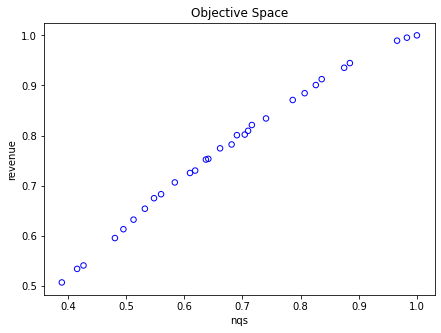

In [65]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 2], -1*F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("nqs")
plt.ylabel("revenue")
plt.show()